# Проект

### Формализация проблемы со стороны заказчика

Сервис доставки с низким удержанием клиентов. Клиенты делают 1 заказ и уходят

### Найденные проблемные точки

**Пункт 1**
- Средний retention после 1 месяца примерно 0.0035. Почти никто не делает повторный заказ вне зависимости от коготы.

**Пункт 2**
- На основании когортного анализа PMF отсутствует
- 12% заказов подтверждают за сутки. Примерно 5% заказов подтверждают более 1 дня (есть заказ, который подтвеждали месяц). На многих платформах это делается моментально
- 8% заказов приезжают позже установленного срока
- 1% заказов отменяют
- У 10% товаров задержка по логистике
- Корзина состоит из 1 товара

**Пункт 3 - метрики**

1 Рост объёма продаж маркетплейса - GMV — Общий объем продаж

2 Объем аудитории, которой продукт доставляет ценность - MAU - Активные пользователи с гранулярностью в месяц

3 Заинтересованность новых клиентов в продукте - Количество купленных товаров (items) с гранулярностью в месяц (то что можем посчитать), вообще было бы здорово иметь данные о регистрации пользователей и времени до первой покупки.

4 Вовлеченность клиента в продолжение использования продукта - Retention - Удержание

5 Денежное выражение вовлеченности клиента - ARPU - Средний доход с пользователя

**Пункт 4 - выбор гипотез**

Приоритетной оказалась 2-ая гипотеза: `Если сократим время до отгрузки заказа, то клиенты перестанут получать свой заказ с запаздыванием, вследствие чего количество заказов увеличится за счёт повторных заказов.` Она повлияет на большее количество юзеров, ее легче всего внедрить и мы полностью в ней уверены (судя по Confidence уже проводились тесты). ICE = 320

**Пункт 5 - метрики чтобы отслеживать гипотезу**

1) Целевые: Количество повторных заказов - удержание

2) Прокси: Среднее время доставки товаров на логистику, % заказов, переданных в срок

3) Guardrail: % отмененных заказов, % просроченных заказов

### Общие выводы и рекомендации

**Общие выводы** 

Почти 20% заказов являются проблемными - надо исправлять процессинг. Но есть ощущение, что даже так компания могла бы жить, но клиенты с "непроблемными заказами" также уходят. Почти во всех заказах присутсвует только 1 продукт. Я больше всего склоняюсь к идее, что надо расширять ассортимент, улучшать поиск товаров и рекомендации.

**Рекомендации**

Идеи:

1) Работать над расширением ассортимента

2) Работать над поисковой системой

3) Работать над рекомендательной системой

4) Хочется больше увидеть картину по регистрациям, времени до первого заказа, как долго клиенту надо офрмлять заказ - было бы здорово собирать эти данные

5) Работать над процессингом: автоматизировать и ускорить процесс подтверждения, не допускать задержки товаров поставщиками, правильно рассчитывать срок доставки

##### Гипотеза 1 : 
`Если расширим ассортимент / улучшим систему поиска / улучшим рекомендации, то клиенты будут находить интересующие их товары, вследствие чего увеличится удержание клиента за счет повторных заказов. `

##### Гипотеза 2 : 
`Если сократим время до отгрузки заказа, то клиенты перестанут получать свой заказ с запаздыванием, вследствие чего количество заказов увеличится за счёт повторных заказов.`

Импорт библиотек

In [73]:
import pandas as pd
from operator import attrgetter
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import numpy as np

Описание датасетов

### olist_customers_dataset.csv — таблица с уникальными идентификаторами пользователей
customer_id — позаказный идентификатор пользователя

customer_unique_id — уникальный идентификатор пользователя (аналог номера паспорта)

customer_zip_code_prefix — почтовый индекс пользователя

customer_city — город доставки пользователя

customer_state — штат доставки пользователя

### olist_orders_dataset.csv —  таблица заказов
order_id — уникальный идентификатор заказа (номер чека)

customer_id — позаказный идентификатор пользователя

order_status — статус заказа

order_purchase_timestamp — время создания заказа

order_approved_at — время подтверждения оплаты заказа

order_delivered_carrier_date — время передачи заказа в логистическую службу

order_delivered_customer_date — время доставки заказа

order_estimated_delivery_date — обещанная дата доставки

### olist_order_items_dataset.csv — товарные позиции, входящие в заказы
order_id — уникальный идентификатор заказа (номер чека)

order_item_id — идентификатор товара внутри одного заказа

product_id — ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date — максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price — цена за единицу товара

freight_value — вес товара 

Считывание файлов

In [2]:
users  = pd.read_csv('olist_customers_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv', parse_dates=[3, 4, 5, 6, 7])
items  = pd.read_csv('olist_order_items_dataset.csv', parse_dates=['shipping_limit_date'])

In [3]:
users.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
users.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [5]:
users.duplicated().sum()

0

По юзерам - все ОК

In [6]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [8]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

1) Есть доставленные заказы без времени оплаты

2) Много незаполненных дат передачи в логистическую службу

3) Есть доставленные товары безвремени доставки

In [9]:
orders.duplicated().sum()

0

In [10]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [11]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


In [12]:
items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [13]:
items.duplicated().sum()

0

## Задача 1: Оценить месячный retention в оформление заказа

Будем оценивать удержание по статусу delivered

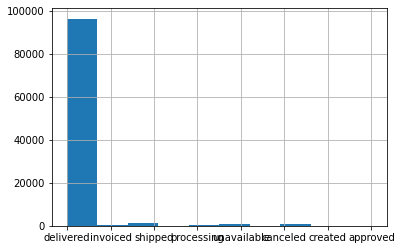

In [14]:
orders.order_status.hist()

In [15]:
orders_delivered = orders.query('order_status == "delivered"')

In [16]:
orders_cohort = orders_delivered[['customer_id','order_id','order_purchase_timestamp']]

In [17]:
orders_cohort.head()

,customer_id,order_id,order_purchase_timestamp
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33
1,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37
2,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49
3,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06
4,8ab97904e6daea8866dbdbc4fb7aad2c,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39


In [18]:
orders_cohort = orders_cohort.merge(
            users[['customer_id', 'customer_unique_id']],
            on='customer_id'
        ).merge(
            items[['order_id','price','order_item_id']],
            on='order_id')

In [19]:
orders_cohort.head()

,customer_id,order_id,order_purchase_timestamp,customer_unique_id,price,order_item_id
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,29.99,1
1,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,118.70,1
2,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,159.90,1
3,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,45.00,1
4,8ab97904e6daea8866dbdbc4fb7aad2c,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,19.90,1


In [20]:
orders_cohort['order_period']     = orders_cohort['order_purchase_timestamp'].dt.to_period('M')
orders_cohort['order_period_day'] = orders_cohort['order_purchase_timestamp'].dt.to_period('D')

In [21]:
orders_cohort.head()

,customer_id,order_id,order_purchase_timestamp,customer_unique_id,price,order_item_id,order_period,order_period_day
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,29.99,1,2017-10,2017-10-02
1,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,118.70,1,2018-07,2018-07-24
2,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,159.90,1,2018-08,2018-08-08
3,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,45.00,1,2017-11,2017-11-18
4,8ab97904e6daea8866dbdbc4fb7aad2c,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,19.90,1,2018-02,2018-02-13


In [22]:
first_purchase = orders_cohort.groupby('customer_unique_id', as_index = False)\
                              .agg({'order_period':'min','order_period_day':'min'})\
                              .rename(columns = {'order_period':'first_month', 'order_period_day':'first_day'})

In [23]:
first_purchase

,customer_unique_id,first_month,first_day
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,2018-05-10
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,2018-05-07
2,0000f46a3911fa3c0805444483337064,2017-03,2017-03-10
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,2017-10-12
4,0004aac84e0df4da2b147fca70cf8255,2017-11,2017-11-14
...,...,...,...
93353,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,2017-06-08
93354,fffea47cd6d3cc0a88bd621562a9d061,2017-12,2017-12-10
93355,ffff371b4d645b6ecea244b27531430a,2017-02,2017-02-07
93356,ffff5962728ec6157033ef9805bacc48,2018-05,2018-05-02


In [24]:
orders_cohort = orders_cohort.merge(first_purchase, on='customer_unique_id')

In [25]:
orders_cohort['period_number_month'] = np.floor((orders_cohort.order_period_day - orders_cohort.first_day).apply(attrgetter('n')) / 30)

In [26]:
# Агрегируем данные по когортам и рассчитанному номеру периода (в месяцах)
df_cohort = orders_cohort.groupby(['first_month', 'period_number_month'], as_index=False)\
                         .agg(n_customers=('customer_unique_id', 'nunique'))

In [27]:
df_cohort

,first_month,period_number_month,n_customers
0,2016-09,0.0,1
1,2016-10,0.0,262
2,2016-10,6.0,1
3,2016-10,9.0,1
4,2016-10,11.0,1
...,...,...,...
210,2018-06,1.0,22
211,2018-06,2.0,6
212,2018-07,0.0,5949
213,2018-07,1.0,6


In [28]:
cohort_pivot = df_cohort.pivot_table(index='first_month', columns='period_number_month', values='n_customers')

In [29]:
cohort_size = cohort_pivot.iloc[:, 0]

In [30]:
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

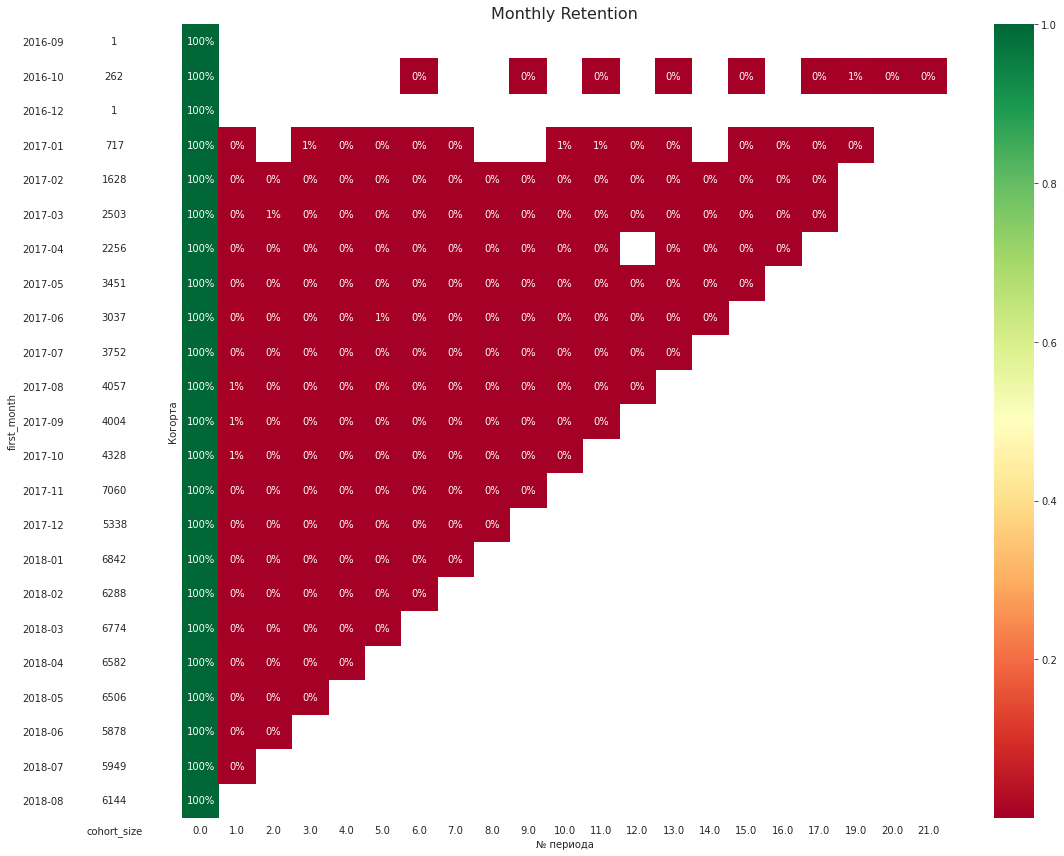

In [31]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(16, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # Тепловая карта для коэффициентов удержания
    sns.heatmap(retention_matrix,
                mask=retention_matrix.isnull(),
                annot=True,
                fmt='.0%',
                cmap='RdYlGn',
                ax=ax[1])
    ax[1].set_title('Monthly Retention', fontsize=16)
    ax[1].set(xlabel='№ периода', ylabel='Когорта')

    # Тепловая карта для размеров когорт
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])

    fig.tight_layout()
    plt.show()

In [32]:
retention_matrix.head()

period_number_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
first_month,,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003817,NaN,NaN,0.003817,...,0.003817,NaN,0.003817,NaN,0.003817,NaN,0.003817,0.007634,0.003817,0.003817
2016-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.002789,NaN,0.005579,0.001395,0.001395,0.002789,0.002789,NaN,NaN,...,0.005579,0.004184,0.002789,NaN,0.002789,0.002789,0.002789,0.001395,NaN,NaN
2017-02,1.0,0.001229,0.001843,0.003686,0.002457,0.001229,0.002457,0.000614,0.001229,0.002457,...,0.003686,0.000614,0.001843,0.001229,0.000614,0.000614,0.001843,NaN,NaN,NaN


In [33]:
retention_1 = retention_matrix[1].median()
print(f"Медианное значение удержание в 1 месяц {retention_1:.2}")

Медианное значение удержание в 1 месяц 0.0035


In [34]:
max_retention_cohort_3 = retention_matrix[3].idxmax()
print(f"Когорта с самым высоким retention на 3-й месяц: {max_retention_cohort_3}")

Когорта с самым высоким retention на 3-й месяц: 2017-01


## Задача 2: Оценить PMF

Product-market fit отсутствует. Удержание клиентов составляет менее 1%

### Общие показатели

Города, откуда чаще всего делают заказы

In [35]:
orders_users =  orders.merge(users, on='customer_id')

In [36]:
orders_users.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [37]:
orders_users['delivery_time'] = (orders_users['order_delivered_customer_date'] - orders_users['order_purchase_timestamp']).dt.days

In [38]:
orders_users.delivery_time.median()

10.0

In [39]:
orders_users.groupby(by='customer_city', as_index=False).agg({'order_id': 'count', 'delivery_time': 'median'})\
                                                        .rename(columns={'order_id': 'ord_cnt', 'delivery_time': 'delivery_med'})\
                                                        .sort_values(by='ord_cnt').tail(10)

,customer_city,ord_cnt,delivery_med
3428,sao bernardo do campo,938,6.0
1529,guarulhos,1189,6.0
3247,salvador,1245,17.0
2964,porto alegre,1379,13.0
707,campinas,1444,8.0
1143,curitiba,1521,8.0
558,brasilia,2131,11.0
453,belo horizonte,2773,9.0
3155,rio de janeiro,6882,11.0
3597,sao paulo,15540,6.0


Штаты, откуда чаще всего делают заказы

In [40]:
orders_users.groupby(by='customer_state', as_index=False).agg({'order_id': 'count', 'delivery_time': 'median'})\
                                                        .rename(columns={'order_id': 'ord_cnt', 'delivery_time': 'delivery_med'})\
                                                        .sort_values(by='ord_cnt').tail(10)

,customer_state,ord_cnt,delivery_med
8,GO,2020,13.0
7,ES,2033,13.0
6,DF,2140,11.0
4,BA,3380,16.0
23,SC,3637,13.0
17,PR,5045,10.0
22,RS,5466,13.0
10,MG,11635,10.0
18,RJ,12852,12.0
25,SP,41746,7.0


В частозаказываемые города-штаты в основном довозят, как и по всем -> PMF низкий в целом

In [41]:
orders_users_items =  orders_users.merge(items, on='order_id')

In [42]:
orders_users_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,delivery_time,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,8.0,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,13.0,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,9.0,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,13.0,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2.0,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [43]:
orders_users_items.groupby(by='customer_unique_id', as_index=False)\
                  .agg({'order_id': 'count'}).describe()

,order_id
count,95420.00000
mean,1.18057
std,0.62145
min,1.00000
25%,1.00000
50%,1.00000
75%,1.00000
max,24.00000


Как и показал когортный анализ, в основном юзеры делают заказ 1 раз

Посмотрим как выглядит обычный заказ

In [44]:
orders_users_items.groupby(by='order_id', as_index=False)\
                  .agg({'product_id': 'count', 'price': 'sum', 'freight_value': 'sum'}).describe()

,product_id,price,freight_value
count,98666.000000,98666.000000,98666.000000
mean,1.141731,137.754076,22.823562
std,0.538452,210.645145,21.650909
min,1.000000,0.850000,0.000000
25%,1.000000,45.900000,13.850000
50%,1.000000,86.900000,17.170000
75%,1.000000,149.900000,24.040000
max,21.000000,13440.000000,1794.960000


### Исследование процесса доставки

Флоу примерно такой: создание - подтверждение - передача в логистику - доставка клиент. Посмотрим сколько в среднем это занимает времени.

In [45]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [46]:
deliver_flow = orders.copy()

In [47]:
deliver_flow['pur_to_app_time'] = (deliver_flow['order_approved_at'] - deliver_flow['order_purchase_timestamp']).dt.days

In [48]:
deliver_flow['app_to_carr_time'] = (deliver_flow['order_delivered_carrier_date'] - deliver_flow['order_approved_at']).dt.days

In [49]:
deliver_flow['carr_to_deliver_est_time'] = (deliver_flow['order_estimated_delivery_date'] - deliver_flow['order_delivered_carrier_date']).dt.days

In [50]:
deliver_flow['carr_to_deliver_time'] = (deliver_flow['order_delivered_customer_date'] - deliver_flow['order_delivered_carrier_date']).dt.days

In [51]:
deliver_flow.describe()

,pur_to_app_time,app_to_carr_time,carr_to_deliver_est_time,carr_to_deliver_time
count,99281.000000,97644.000000,97658.000000,96475.000000
mean,0.269800,2.301749,20.170124,8.878310
std,0.986202,3.560283,8.766485,8.746088
min,0.000000,-172.000000,-100.000000,-17.000000
25%,0.000000,0.000000,14.000000,4.000000
50%,0.000000,1.000000,20.000000,7.000000
75%,0.000000,3.000000,25.000000,12.000000
max,187.000000,125.000000,192.000000,205.000000


Баги: 

1 - есть заказы, которые подтверждают после того, как товар уже отправлен

2 - есть заказы, которые переданы в службу доставки уже после получения клиентом

In [52]:
deliver_flow.query('carr_to_deliver_time < 0').head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,pur_to_app_time,app_to_carr_time,carr_to_deliver_est_time,carr_to_deliver_time
6437,a1abeb653a4d4cd1e142ccb8c82cd069,5f50465da00b7fed5dd1239f4ecf6e2c,delivered,2017-07-20 11:20:52,2017-07-21 06:43:14,2017-07-28 16:57:58,2017-07-25 19:32:56,2017-08-14,0.0,7.0,16.0,-3.0
9553,383aa8b2724fe452d9ccd9934a8c628b,b1cb2f9d7a19480f3749e248db14d58f,delivered,2017-07-02 20:58:43,2017-07-02 21:10:20,2017-07-07 17:22:41,2017-07-06 14:27:51,2017-07-21,0.0,4.0,13.0,-2.0
13487,cb1134f9010d242e9515ad1c78ec0c39,2fd33ac77677bd214b1882868317eeed,delivered,2017-07-16 12:35:34,2017-07-18 06:03:50,2017-07-20 19:22:02,2017-07-19 14:13:28,2017-08-08,1.0,2.0,18.0,-2.0
14474,dceb62e8fa94b46006c9554fed743df0,2721900eb4e0f1cc2c836dd7bc1b1e11,delivered,2017-07-20 20:58:05,2017-07-22 11:45:11,2017-08-01 18:23:30,2017-07-26 18:09:10,2017-08-11,1.0,10.0,9.0,-7.0
19268,5f9d46795c3126674e52becb3a1a517f,79287bcaafdde5c793b996fc40bb7d9f,delivered,2017-07-18 11:48:20,2017-07-18 12:03:29,2017-07-20 23:03:42,2017-07-20 18:52:41,2017-07-31,0.0,2.0,10.0,-1.0


In [53]:
deliver_flow = deliver_flow.query('app_to_carr_time >= 0 and carr_to_deliver_time >= 0')

In [54]:
deliver_flow.describe()

,pur_to_app_time,app_to_carr_time,carr_to_deliver_est_time,carr_to_deliver_time
count,95088.000000,95088.000000,95088.000000,95088.000000
mean,0.241124,2.351832,20.142521,8.910578
std,0.666324,3.491075,8.747407,8.756023
min,0.000000,0.000000,-100.000000,0.000000
25%,0.000000,0.000000,14.000000,4.000000
50%,0.000000,1.000000,20.000000,7.000000
75%,0.000000,3.000000,25.000000,12.000000
max,30.000000,125.000000,148.000000,205.000000


12% заказов подтверждают за сутки. Примерно 5% заказов подтверждают более 1 дня (есть заказ, который подтвеждали месяц). На многих платформах это делается моментально

In [55]:
deliver_flow.query('pur_to_app_time == 1').shape[0] / deliver_flow.shape[0] * 100

12.171882887430591

8 процентов заказов приезжают позже установленного срока

In [56]:
deliver_flow.query('carr_to_deliver_time > carr_to_deliver_est_time').shape[0] / deliver_flow.shape[0] * 100

7.637136126535419

1% заказов отменяют

In [57]:
status = ['unavailable', 'canceled']
orders.query('order_status in @status').shape[0] / orders.shape[0]* 100

1.2409368369183738

In [58]:
orders_users_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,delivery_time,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,8.0,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,13.0,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,9.0,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,13.0,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2.0,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


Посмотрим успевают ли товары вовремя привезти для передачи в логистику

In [61]:
max_lim = orders_users_items.groupby(by='order_id', as_index=False)\
                            .agg({'shipping_limit_date': 'max'})\
                            .rename(columns={'shipping_limit_date': 'max_limit'})

In [62]:
orders_users_items = orders_users_items.merge(max_lim, on='order_id')

In [65]:
orders_users_items.query('order_delivered_carrier_date > max_limit').shape

(10405, 20)

У 10 процентов товаров задержка по логистике

In [67]:
orders_users_items.query('order_delivered_carrier_date > max_limit').shape[0] / orders_users_items.shape[0] * 100

9.236573457612073

## Задача 3: Определить 5 основных метрик

1 Рост объёма продаж маркетплейса - GMV — Общий объем продаж

2 Объем аудитории, которой продукт доставляет ценность - MAU - Активные пользователи с гранулярностью в месяц

3 Заинтересованность новых клиентов в продукте - Количество купленных товаров (items) с гранулярностью в месяц (то что можем посчитать), вообще было бы здорово иметь данные о регистрации пользователей и времени до первой покупки.

4 Вовлеченность клиента в продолжение использования продукта - Retention - Удержание

5 Денежное выражение вовлеченности клиента - ARPU - Средний доход с пользователя

### GMV

In [84]:
orders_users_items['month'] =  orders_users_items.order_approved_at.dt.to_period('M')

In [91]:
GMV = orders_users_items.groupby(by='month', as_index=False).agg({'price': 'sum'})

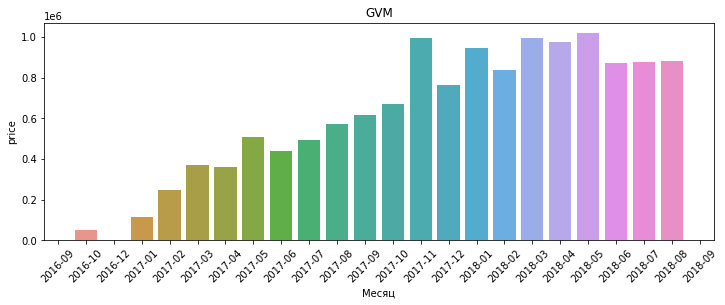

In [102]:
plt.figure(figsize=(12, 4))
sns.barplot(data=GMV, x=GMV.month, y=GMV.price)
plt.title('GVM')
plt.xlabel('Месяц')
plt.xticks(rotation=45)
plt.show()

### MAU

In [109]:
MAU = orders_users_items.groupby(by='month', as_index=False).agg({'customer_unique_id': 'nunique'})

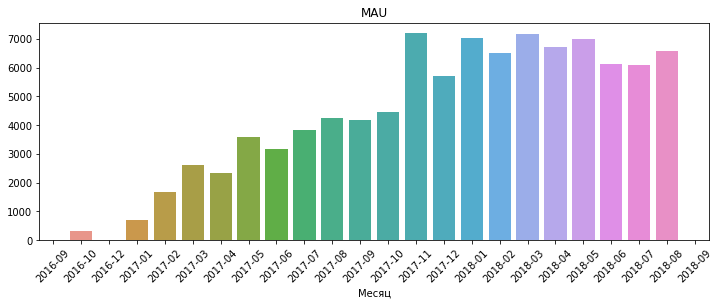

In [110]:
plt.figure(figsize=(12, 4))
sns.barplot(data=MAU, x=MAU.month, y=MAU.customer_unique_id)
plt.title('MAU')
plt.xlabel('Месяц')
plt.ylabel('')
plt.xticks(rotation=45)
plt.show()

### Retention

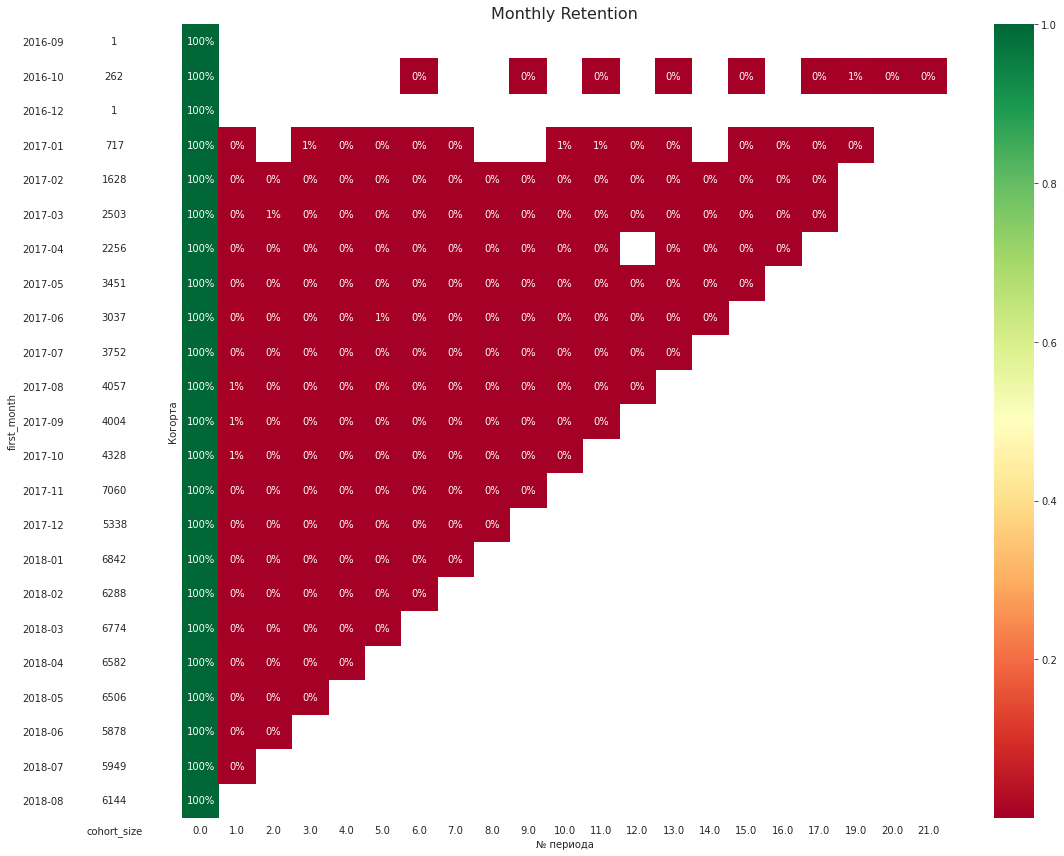

In [108]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(16, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # Тепловая карта для коэффициентов удержания
    sns.heatmap(retention_matrix,
                mask=retention_matrix.isnull(),
                annot=True,
                fmt='.0%',
                cmap='RdYlGn',
                ax=ax[1])
    ax[1].set_title('Monthly Retention', fontsize=16)
    ax[1].set(xlabel='№ периода', ylabel='Когорта')

    # Тепловая карта для размеров когорт
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])

    fig.tight_layout()
    plt.show()

### ARPU

In [114]:
ARPU = GMV.merge(MAU, on='month')

In [116]:
ARPU['avg_price'] = ARPU.price / ARPU.customer_unique_id

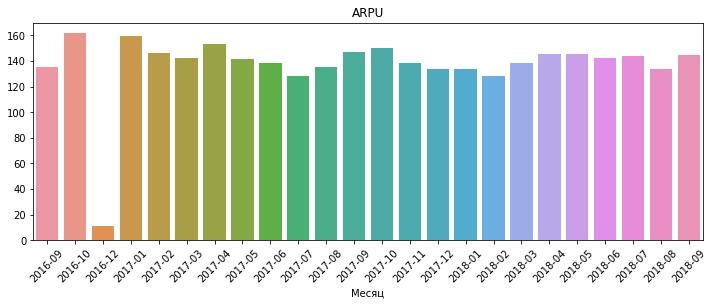

In [117]:
plt.figure(figsize=(12, 4))
sns.barplot(data=ARPU, x=ARPU.month, y=ARPU.avg_price)
plt.title('ARPU')
plt.xlabel('Месяц')
plt.ylabel('')
plt.xticks(rotation=45)
plt.show()

## Задача 4: Приоритезация гипотез по ICE

In [118]:
df_ice = orders[orders['order_purchase_timestamp'] >= pd.to_datetime('2017-06-01')]

In [120]:
df_ice.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


`Если исправим баг в системе процессинга заказов, то клиентам не придётся сталкиваться с проблемой отмены заказа, вследствие чего количество доставленных заказов увеличится. Считаем, что мы таким образом избавимся от всех отмен.`

In [121]:
status = ['canceled', 'unavailable']
impact_1 = df_ice.query('order_status in @status')

In [124]:
impact_1.shape

(974, 8)

Impact 1-ой гипотезы = 5

ICE 1-ой гипотезы = 240

`Если сократим время до отгрузки заказа, то клиенты перестанут получать свой заказ с запаздыванием, вследствие чего количество заказов увеличится за счёт повторных заказов. `

In [127]:
impact_2 = df_ice.query('order_delivered_customer_date > order_estimated_delivery_date')

In [128]:
impact_2.shape

(7296, 8)

Impact 2-ой гипотезы = 8

ICE 1-ой гипотезы = 320

`Если создадим новый способ оплаты, который будет конвертировать клиентов в повторный заказ, то клиенты не будут испытывать трудности при оформлении заказа, вследствие чего количество заказов увеличится за счёт повторных заказов.`

In [129]:
df_ice_2 = orders_users.query('order_status == "delivered"')

In [130]:
median_retention = 0.0035

In [131]:
impact3 = df_ice_2['customer_unique_id'].nunique() * median_retention

In [132]:
impact3

326.753

Impact 3-ей гипотезы = 3

ICE 3-ей гипотезы = 135

##### Наиболее значимой гипотезой является 2-ая - нужно менять процессинг заказов

## Задача 5: Формулировка целей к выбранной гипотезе

1) Целевые:    Число вовремя доставленных, время до отгрузки, количество повторных заказов

2) Прокси:     Время доставки товаров на логистику

3) Guardrail:  Количество отмененных заказов, количество просроченных заказов